In [1]:
%load_ext autoreload
%autoreload 2

from utils import * 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

set_latex_fonts()

# Problem 1 - Convergence tests

## 1.A) Timestep convergence

- Determine a suitable timestep for molecular dynamics simulations at the highest simulated temperature (800 K) by analyzing the conservation of the total energy (the constant of motion, defined as the sum of the potential and knetic energies). You can read the energies (E for potential energy and K for kinetic energy) from the output file (e.g., E of t 6 800 0.001.dat)

- Since the total energy is not perfectly constant due to numerical integration errors, quantify these fluctuations by calculating the standard deviation of the total energy over time for different timesteps. Plot the standard deviation of the total energy as a function of the timestep. 

- Based on your simulations, select a timestep where the standard deviation of the total energy fluctuations is below $1\times10^{-5}$ eV/atom.

**Note**: Note: The standard deviation should be reported per atom. The unit cell contains 4 atoms; so e.g. in a 2×2×2 supercell there are 32 atoms.

Converged timesteps:
         Standard Deviation  Converged
0.00005        5.801133e-07       True
0.00010        6.205978e-07       True
0.00050        6.159795e-07       True
0.00100        1.354201e-06       True
0.00200        3.409286e-06       True
0.00300        9.472080e-06       True
0.00400        9.933270e-06       True

Not converged timesteps:
       Standard Deviation  Converged
0.005            0.000024      False
0.006            0.000025      False
0.007            0.000030      False
0.008            0.000042      False
0.009            0.000079      False
0.010            0.000103      False
0.020            0.000324      False
0.030            0.000673      False
0.040            0.002212      False
0.050            0.257492      False


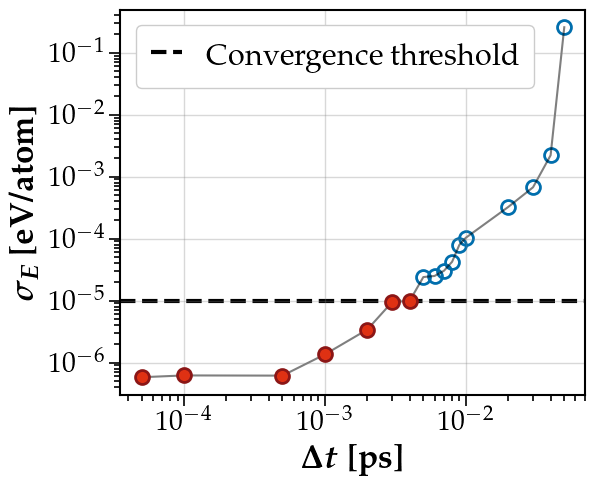

In [2]:
timesteps = [0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]
filepaths = create_filepaths(timesteps)
data, total_energies = compute_total_energy(timesteps, filepaths)
plot_std_devs(timesteps, total_energies, convergence_threshold=1e-5, n_atoms=32)

Based on the data and the plot, we choose a timestep of **0.002 picosecond** (we could have chosen 0.003 or 0.004, but these two values are really close to the threshold). 

## 1.B) Supercell convergence
- Converge the system supercell size such that the standard deviation of temperature is below 3% of the target temperatures (293 K and 800 K). 

- How does the standard deviation decrease with increased system size (number of atoms)? 

In [3]:
temps = [293, 800]
supercell_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
convergence_threshold = 3 / 100
df = supercell_convergence_df(temps, supercell_sizes)
display(df)

,Std T=293,Ratio T=293,Std T=800,Ratio T=800,N_atoms
Supercell Size,,,,,
2,35.918875,0.122590,81.332801,0.101666,32
3,19.582147,0.066833,40.328741,0.050411,108
4,11.690569,0.039900,28.087871,0.035110,256
5,8.325228,0.028414,19.115919,0.023895,500
6,6.902141,0.023557,17.806276,0.022258,864
7,9.694711,0.033088,14.239791,0.017800,1372
8,7.849056,0.026789,9.964995,0.012456,2048
9,8.970647,0.030617,9.257307,0.011572,2916
10,9.689710,0.033071,7.507545,0.009384,4000


In [4]:
fitted_params, fitted_uncertainties = fit_fluctuation_power_law(df, temps, True, confidence_levels=[1.96])


===== Fit results for T=293 K=====

Power law exponent: -0.5203 ± 0.0125

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.11228   0.74561  +0.13564
 b:  -0.04095  -0.52027  +0.03895


===== Fit results for T=800 K=====

Power law exponent: -0.4994 ± 0.0163

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.08769   0.56478  +0.10723
 b:  -0.04080  -0.49939  +0.03807



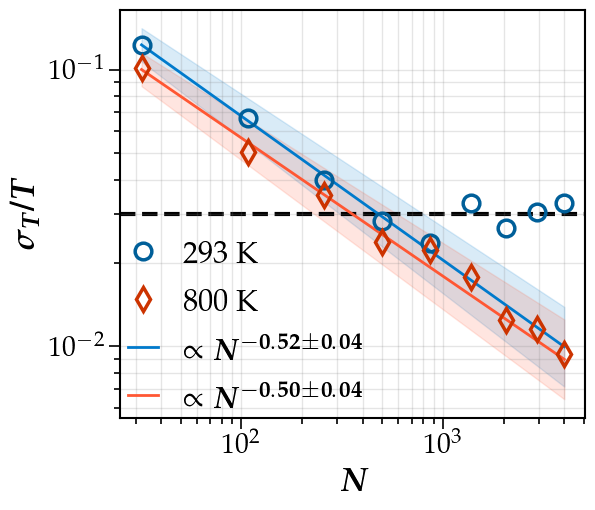

In [5]:
markers = ['o', 'd', 's', 'v', 'D', '+']
marker_colors = ['#005f99', '#cc3300', "#157c3e", '#a64d79', '#ff9933', '#000000']
line_colors = ['#007acc', '#ff5733', '#2ecc71', '#9b59b6', "#ffc972", "#5E5E5E"]

plt.figure(figsize=(6, 5.3))
for T, marker, marker_color, line_color in zip(temps, markers, marker_colors, line_colors):
    plt.loglog(df["N_atoms"], df[f"Ratio T={T}"], marker=marker, label=rf'${T}$ K', markersize=12, markeredgecolor=marker_color,
             markerfacecolor='none', markeredgewidth=2.5, color=line_color, linestyle='None', zorder=3)

x_plot = np.linspace(df["N_atoms"].min(), df["N_atoms"].max(), 1000)
for T, params, uncertainties, color in zip(temps, fitted_params.values(), fitted_uncertainties.values(), line_colors):
    a, b = params['a'], params['b']
    a_err, b_err = uncertainties[0], uncertainties[1]
    
    # b_ci is read from the 95% confidence interval of the fit
    # since we only care about the power law exponent, we consider a as a constant
    b_ci = 0.04 
    y_plot = a * x_plot ** b
    y1 = a * x_plot ** (b - b_ci)
    y2 = a * x_plot ** (b + b_ci)
    plt.fill_between(x_plot, y1, y2, alpha=0.15, color=color, zorder=1)
    plt.loglog(x_plot, y_plot, label=rf'$\propto \boldsymbol N^{{\mathbf{{{b:.2f} \pm {b_ci:.2f}}}}}$',color=color, linewidth=2, zorder=2)
plt.axhline(y=convergence_threshold, color='black', linestyle='--', linewidth=3, zorder=1)
plt.xlabel(r'$\boldsymbol{N}$')
plt.ylabel(r'$\boldsymbol{\sigma_T/T}$')

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
# plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.35), frameon=True)
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=(-0.05, -0.07))

plt.grid(which='both', linestyle='-', linewidth=1, alpha=0.2)
plt.show()

Convergence to $0.03T$ is obtained for both cases.
- At 293 K, a plateau is reached around the threshold for a supercell size of $5$, corresponding to $N=5^3\times 4 = 500$ atoms. 
- At 800 K a monotonic decrease is observed. The same supercell size is required for convergence. 

In both cases, a power law decay of $\sigma_T$ is visible
- At 293 K, the exponent is $-0.52\pm0.04$. The error corresponds to 95% confidence interval.
- At 800 K, the exponent is $-0.50\pm0.04$ 

These resuls are consistent with the statistical mechanics prediction (exponent $-0.5$) $\sigma_T/T \sim 1/\sqrt N$. 

From now on, we use a supercell size of 6.

## 1.C) Ideal production length

- Estimate the ideal production length from the velocity auto-correlation function $\text{VAF}(t)$ at room temperature (293 K).

- Explain why this estimate should be made at the lowest temperature you plan to simulate.

- Derive how the value of $\text{VAF}(t=0)$ is related to $\langle  E_{kin}\rangle$, and check this for one of your trajectories. 

c:\Users\celin\OneDrive\Bureau\MSE468_VM\lab4\utils.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


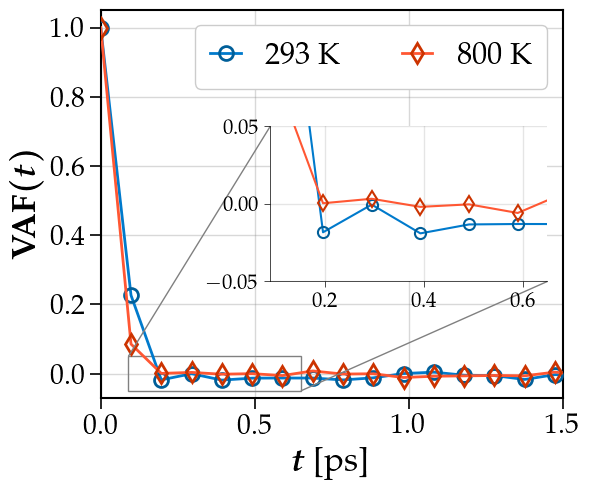

In [6]:
# Here we used a timesteps of 0.001 instead of 0.002
T = [293, 800]
filepaths = [f"P1/VAF/vaf_{t}.dat" for t in T]
list_df_vaf = plot_VAF(filepaths, T)

The production time (decorrelation time) derived from the plot is 0.6 ps. We clearly observe that the VAF decays faster at higher temperature. 

If we simulate during  $nt_c$, we will get $n$ independent estimates of a quantity to average.

In [7]:
T = 293
df_vaf = list_df_vaf[0]
E_kin_file = f"P1/VAF/E_of_t_6_{T}_0.001.dat" 
avg_E_kin = np.mean(load_data(E_kin_file)["K (eV)"]) 
print(f"Average kinetic energy at {T} K: {avg_E_kin:.4f} eV")

m_Ag = 107.8682
m_I = 126.90447
N_Ag = 432 
N_I = 432
m_avg = (N_Ag*m_Ag + N_I*m_I) / (N_Ag + N_I)

vaf_0 = df_vaf['VAF(t)'].iloc[0]
predicted_vaf_0 = 2 * avg_E_kin / (3 * m_avg)
print(f"VAF(0) value: {vaf_0:.4e}")
print(f"Predicted from kinetic energy: {predicted_vaf_0:.4e}")
print(f"Ratio (should be close to 1): {vaf_0/predicted_vaf_0:.4f}")

Average kinetic energy at 293 K: 33.7148 eV
VAF(0) value: 2.1273e+00
Predicted from kinetic energy: 1.9147e-01
Ratio (should be close to 1): 11.1099


# Problem 2 - Structural and dynamical properties of silver iodide

**IMPORTANT**: Make sure to change your ensemble to NVT in the input
script before attempting this problem

## 2.A) Radial distribution function
- Plot the radial distribution function (RDF) at room temperature (293 K) for both species
- Then, show the same plot at a very low temperature (e.g. 10 K) and explain the differences

**Note** express all lengths in angstrom [$\AA$]

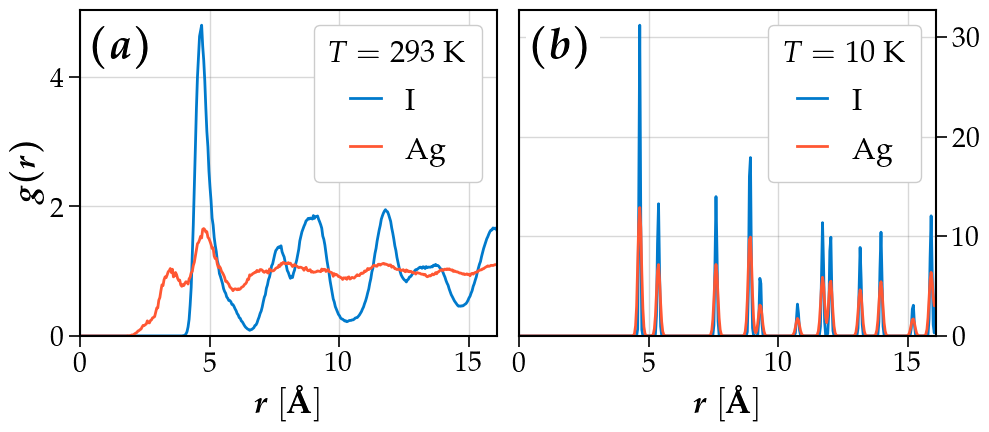

In [8]:
n_bins = [400]
filepaths_293 = [f"P2/RDF/T=293/rdf_{n}bins_1stepsize.dat" for n in n_bins]
list_df_rdf_293 = [load_rdf_data(fp) for fp in filepaths_293]
filepaths_10 = [f"P2/RDF/T=10/rdf_{n}bins_1stepsize.dat" for n in n_bins]
list_df_rdf_10 = [load_rdf_data(fp) for fp in filepaths_10]
plot_rdf(list_df_rdf_293, list_df_rdf_10, n_bins)

## 2.B) Mean square deviation

- For both Ag and I ions, plot the MSD(t) as a function of time for six distinct temperatures within the range 293 K to 800 K.
- What can you infer about the mobility of the two species as the temperature changes?

**NOTE**: Give the MSD in units of [$\AA^2$] and times in picoseconds [ps]

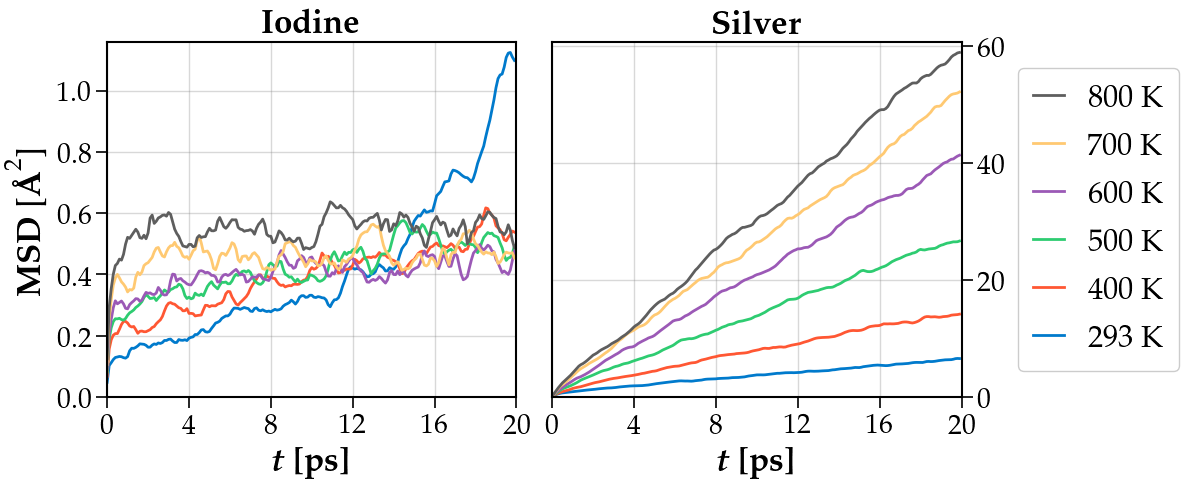

In [40]:
T = [293, 400, 500, 600, 700, 800]
t_sim = 20
dt = 4
filepaths = [f"P2/MSD/E_of_t_6_{t}_0.002.dat" for t in T]
list_df_msd = [load_data(fp)[["t (ps)", "MSD_I", "MSD_Ag"]] for fp in filepaths]
plot_msd_AgI(list_df_msd, T, t_sim, dt)

## 2.C) Diffusion coefficient of Ag
- Estimate the diffusion coefficient for Ag at room temperature 

**Hint**: focus on a region of the MSD(t) curve that is roughly linear and perform a fit.

**Note**: to be consistent with the literature, the diffusion coefficient should be expressed in units of [$\text{cm}^2/\rm s$]

In [41]:
# t_min allows to select the minimum time for the fit, in ps
model = Model(linear_function)
df = fit_msd(list_df_msd, T, model=model, t_min=8, verbose=True)

==== Results for T=293 K ====
slope: 0.2862 ± 0.0017 (units: ps^(-1)*A^2)

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.00333   0.28615  +0.00333
 b:  -0.04783   0.76256  +0.04783


==== Results for T=400 K ====
slope: 0.6525 ± 0.0055 (units: ps^(-1)*A^2)

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.01097   0.65250  +0.01097
 b:  -0.15764   1.47506  +0.15764


==== Results for T=500 K ====
slope: 1.3316 ± 0.0069 (units: ps^(-1)*A^2)

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.01359   1.33162  +0.01359
 b:  -0.19535   0.83072  +0.19535


==== Results for T=600 K ====
slope: 2.0256 ± 0.0096 (units: ps^(-1)*A^2)

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.01909   2.02556  +0.01909
 b:  -0.27438   0.76731  +0.27438


==== Results for T=700 K ====
slope: 2.5985 ± 0.0129 (units: ps^(-1)*A^2)

 Confidence Report:
      95.00%    _BEST_    95.00%
 a:  -0.02562   2.59853  +0.02562
 b:  -0.36821   0.14412  +0.36821


==== Resul

In [42]:
# Compute the diffusion coefficient and convert it to cm^2/s
dim = 3
df["D [A^2/ps]"] = df["Slope (ps^(-1)*A^2)"] / (2 * dim)
df["D [cm^2/s]"] = df["D [A^2/ps]"] * (1e-8)**2 * 1e12
display(df)

,Temperature (K),Slope (ps^(-1)*A^2),Uncertainty (ps^(-1)*A^2),D [A^2/ps],D [cm^2/s]
0,293,0.286151,0.001680,0.047692,0.000005
1,400,0.652501,0.005538,0.108750,0.000011
2,500,1.331622,0.006863,0.221937,0.000022
3,600,2.025561,0.009640,0.337593,0.000034
4,700,2.598529,0.012936,0.433088,0.000043
5,800,2.958509,0.016074,0.493085,0.000049


## 2.D) Diffusion coefficient and Arrhenius law

- Repeat the procedure from the previous point to calculate the diffusion coefficient for Ag at all six temperatures you simulated for point B.
- Subsequently, plot the natural logarithm of the diffusion coefficients versus the inverse of the temperature. Fit the data to verify Arrhenius law and provide an estimate for the activation energy Ea and the pre-exponential factor $D_0$

**Note**: report the activation energy in units of [$\rm cal\cdot mol^{-1}$]

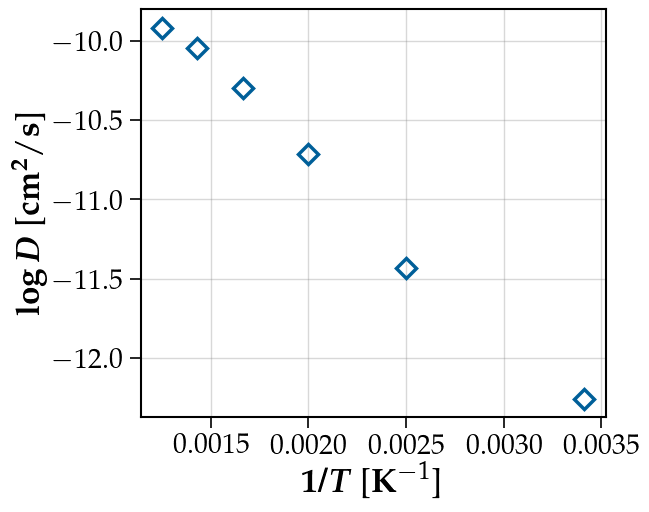

In [ ]:
def exponential_fit(T, D_0, E_a): 
    N_a = 6.02214076e23  # Avogadro's number
    k_B = 1.380649e-23   # Boltzmann constant in J/K
    R = N_a * k_B
    return D_0 * np.exp(-E_a / (R * T))

model = Model(exponential_fit)
T = df["Temperature (K)"].values



plt.figure(figsize=(6, 5.3))
plt.plot(1 / df["Temperature (K)"], np.log(df["D [cm^2/s]"]), marker='D', markersize=10, color='#005f99', markeredgecolor=marker_colors[0], markerfacecolor='none', markeredgewidth=2.5, linestyle='None')
plt.xlabel(r'$\boldsymbol{1/T}$ [$\textbf{K}^{-1}$]')
plt.ylabel(r'$\boldsymbol{\log D}$ [$\textbf{cm}^{\boldsymbol 2}/\textbf{s}$]')
plt.grid()
plt.show()